In [6]:
from src.utils.audio_utils import compute_mel_spectrogram, compute_spectrogram, load_audio_file, padding_audio
import matplotlib.pyplot as plt
import os
import torch
nn = torch.nn
from src.utils import path_utils
import torchinfo
import torchvision
from tqdm import tqdm

/Users/paulbp_dty/Desktop/P3_BBF/audio_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BasicModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linear = nn.Linear(128, 2)
  
  def forward(self, x):
    x = self.main(x)
    # global average pooling
    x = nn.functional.avg_pool2d(x, kernel_size=x.shape[2:]).view(x.shape[0], -1)
    x = self.linear(x)
    return x


# Sliding Window

In [3]:
class SlidingDataset(torch.utils.data.Dataset):
    def __init__(self, raw_dir, transform_audio, window_size, stride):

        self.tensor_directory = raw_dir
        self.transform_audio = transform_audio
        self.reshape_size = (129, 229)
        self.transform_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize(self.reshape_size)])
        self.files = os.listdir(raw_dir)
        self.window_size = window_size
        self.stride = stride
        self.data_tuples = []

        for f in self.files:
            file = os.path.join(raw_dir, f)
            data, fs = load_audio_file(file)
            # pad with zeros with tensor is not of right length
            data = padding_audio(data, self.window_size)
            idxs = [i for i in range(0, data.size - self.window_size, self.stride)]
            if len(idxs) == 0:
                continue
            for j in idxs:
                data_tuple = (file, j)
                self.data_tuples.append(data_tuple)


    def __len__(self):
        return len(self.data_tuples)

    def __getitem__(self, idx):
        sample_tuple = self.data_tuples[idx]
        sample, _ = load_audio_file(sample_tuple[0])
        sample = sample[sample_tuple[1]: sample_tuple[1] + self.window_size]
        sample = self.transform_audio(sample)
        sample = self.transform_image(sample)
        return {'sample': sample, 'file': sample_tuple[0], 'index': sample_tuple[1]}

In [4]:
def smoothe_events(events):

  events.sort(key=lambda x: x[1]) #sort by index


  start = -1000
  stop = -1000


  max_silence = 0.4
  max_silence = 0.6
  min_dur = 1.3
  min_dur= 3.4


  count = 0

  while count < len(events) - 1:
    if (events[count][1] >= events[count + 1][0]) or (events[count + 1][0] - events[count][1] <= max_silence):
      events[count][1] = max(events[count + 1][1], events[count][1])
      del events[count + 1]
    else:
      count += 1

  smooth_events=events
  count = 0
  while count < len(smooth_events):
    if smooth_events[count][1] - smooth_events[count][0] < min_dur :
      del smooth_events[count]
      count += 1
  smooth_events.sort(key=lambda x: x[1])

  return smooth_events

In [5]:
def transform_audio(data):
    _, _, specto = compute_spectrogram(data, 24000, nperseg=256, noverlap=256/2, scale="dB")
    # freq clip
    specto = specto[:120, :]
    return specto
detection_dataloader = torch.utils.data.DataLoader(SlidingDataset(raw_dir=path_utils.get_raw_data_path(),
                                                    transform_audio=transform_audio, 
                                                    window_size=24000, stride=12000),
                                                    batch_size=1, 
                                                    drop_last=True)

In [ ]:
model = BasicModel()
model.load_state_dict(torch.load('./cnnnet.pth', map_location=torch.device('cpu')))
for x in detection_dataloader:
  print(x['sample'].shape)
  logits=model(x['sample'])
  print(torch.argmax(logits, dim=1).numpy().tolist())

# Selective Search

In [58]:
import librosa.display
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import selectivesearch
import cv2
import pandas as pd

timestamp_start=3500
timestamp_end=3560
raw_sample=os.path.join(path_utils.get_raw_data_path(), 'SMA01214_20210927_200004.wav')
y,sr= load_audio_file(raw_sample)
y=y[timestamp_start*sr:timestamp_end*sr]
mels = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=1024,hop_length=512,n_mels=128,fmin=000,fmax=4000)
fig = plt.Figure()
ax = fig.add_subplot(111)
p = librosa.display.specshow(librosa.power_to_db(mels, ref=np.max), ax=ax,)
fig.savefig('spec.png',bbox_inches='tight')

In [59]:
img= cv2.cvtColor(cv2.imread('spec.png'), cv2.COLOR_RGB2BGR)
img_lbl, regions = selectivesearch.selective_search(img, scale=400, sigma=0.8, min_size=30)
regions[:10]

[{'rect': (0, 0, 351, 234), 'size': 7273, 'labels': [0.0]},
 {'rect': (12, 5, 333, 0), 'size': 334, 'labels': [1.0]},
 {'rect': (12, 6, 333, 0), 'size': 334, 'labels': [2.0]},
 {'rect': (9, 7, 0, 217), 'size': 218, 'labels': [3.0]},
 {'rect': (11, 7, 333, 212), 'size': 68742, 'labels': [4.0]},
 {'rect': (11, 7, 146, 177), 'size': 323, 'labels': [5.0]},
 {'rect': (158, 7, 186, 0), 'size': 187, 'labels': [6.0]},
 {'rect': (345, 7, 1, 212), 'size': 214, 'labels': [7.0]},
 {'rect': (10, 8, 0, 212), 'size': 213, 'labels': [8.0]},
 {'rect': (340, 8, 4, 39), 'size': 56, 'labels': [9.0]}]

212.0
9.75
7.777777777777778
0.13793103448275862


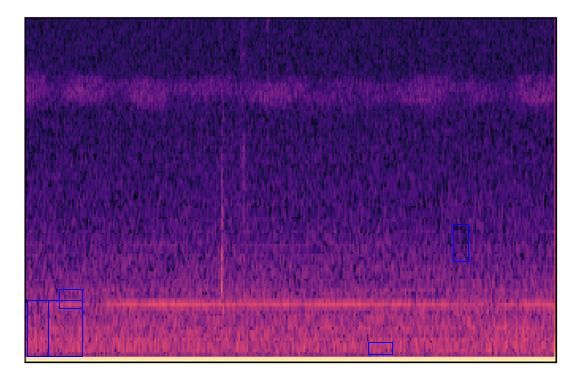

In [60]:
candidates = set()
for r in regions:
    x, y, w, h = r['rect']
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue
    # excluding regions smaller than 50 pixels
    if h*w < 100 or h*w > 3000:
        continue
    if h/w > 5 or w/h > 5:
        print(h/w)
        continue
    # distorted rects
    candidates.add(r['rect'])
# draw rectangles on the original image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.imshow(img)
for x, y, w, h in candidates:
    rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(rect)
plt.axis('off')
plt.show()

# Selective search with openCV

In [29]:
import time
import cv2
import random

Time of Selective Search : 1.8404490947723389
1721
(235, 352, 3)
0.0029940119760479044
0.006006006006006006
0.005970149253731343
0.01680672268907563
73.33333333333333
0.006006006006006006
0.0029940119760479044
0.05263157894736842
72.66666666666667
0.06363636363636363
0.003003003003003003
220.0
109.0
0.008928571428571428
73.33333333333333
0.0029585798816568047
0.028985507246376812
0.06481481481481481
108.5
0.015384615384615385
0.09803921568627451
0.00980392156862745
0.012658227848101266
0.0034482758620689655
0.061452513966480445
0.005970149253731343
0.011904761904761904


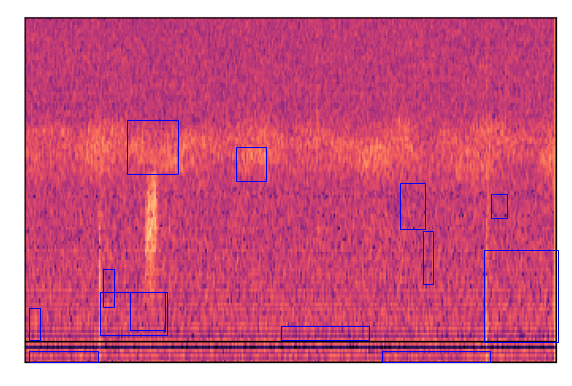

In [33]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)

max_proposal_infer=50
#ss.switchToSelectiveSearchQuality()
start =time.time()
ss.switchToSelectiveSearchQuality()
rects = ss.process()
end = time.time()
print("Time of Selective Search :",end-start)
print(len(rects))
# loop over the region proposals in chunks (so we can better
# visualize them)
#for i in range(max_proposal_infer):
    # clone the original image so we can draw on it
output = img.copy()
print(np.shape(output))
    # loop over the current subset of region proposals
candidates=set()
for (x,y,w,h) in rects[:max_proposal_infer]:
    # excluding regions too small or too large or too distorded
    if h*w < 100 or h*w > 3000:
        continue
    if h/w > 10 or w/h > 10:
        print(h/w)
        continue
    candidates.add((x,y,w,h))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.imshow(img)
for (x, y, w, h) in candidates:
        # draw the region proposal bounding box on the image
    rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(rect)
plt.axis('off')
plt.show()

# ROI with CWT

In [73]:
def _energy_windowed(s, wl=512, fs=None):
    """ 
    Computse windowed energy on an audio signal.
    
    Computes the energy of the signals by windows of length wl. Used to amplify sectors where the density of energy is higher
    
    Parameters
    ----------
    s : ndarray
        input signal
    wl : float
        length of the window to summarize the rms value
    fs : float
        frequency sampling of the signal, used to keep track of temporal information of the signal

    Returns
    -------
    time : ndarray
        temporal index vector
    s_rms : ndarray
        windowed rms signal
    """
    
    s_aux = np.lib.pad(s, (0, wl-len(s)%wl), 'reflect')  # padding
    s_aux = s_aux**2 
    #  s_aux = np.abs(s_aux) # absolute value. alternative option
    s_aux = np.reshape(s_aux,(int(len(s_aux)/wl),wl))
    s_rms = np.mean(s_aux,1)
    time = np.arange(0,len(s_rms)) * wl / fs + wl*0.5/fs
    return time, s_rms
from scipy import signal


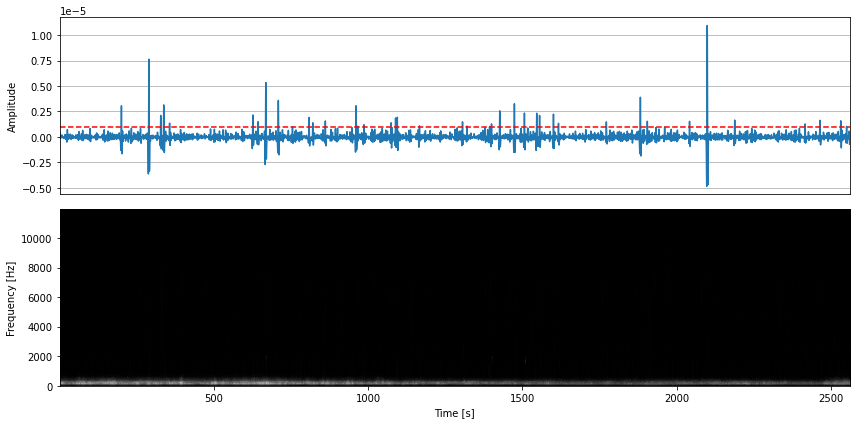

In [72]:
from maad import rois
raw_sample=os.path.join(path_utils.get_raw_data_path(), 'SMA01214_20211002_040012.wav')
s, fs = load_audio_file(raw_sample)
s=s[:2560*fs]
df=rois.find_rois_cwt(s, fs, flims=(1000,3000), tlen=2, th=1e-6, display=True)


In [62]:
class ROIDataset(torch.utils.data.Dataset):
    def mix_to_mono(self, sample):
        if len(sample.shape) == 2:
            return sample
        else:
            return np.mean(sample, axis=1)

    def __init__(self, raw_dir, transform_audio, filter=(1000,3000), len=2, threshold=1e-6):
        self.tensor_directory = raw_dir
        self.transform_audio = transform_audio
        self.reshape_size = (129, 229)
        self.transform_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        self.files = ['SMA01214_20210927_200004.wav']
        self.data_tuples = []
        self.filter=filter
        self.len=len
        self.threshold=threshold

        for f in self.files:
            file = os.path.join(raw_dir, f)
            data, fs = load_audio_file(file)
            # pad with zeros with tensor is not of right length
            roi_df=rois.find_rois_cwt(data, fs, flims=self.filter, tlen=self.len, th=self.threshold, display=False)
            roi_df.iloc[:,np.r_[1,3]].to_numpy()
            for idx in roi_df.iloc[:,np.r_[1,3]].to_numpy():
                data_tuple = (file, idx)
                self.data_tuples.append(data_tuple)


    def __len__(self):
        return len(self.data_tuples)

    def __getitem__(self, idx):
        sample_tuple = self.data_tuples[idx]
        sample, fs = load_audio_file(sample_tuple[0])
        sample = sample[int(sample_tuple[1][0]*fs):int(sample_tuple[1][1]*fs)]
        sample = self.transform_audio(sample)
        sample = self.transform_image(sample)
        return {'sample': sample, 'file': sample_tuple[0], 'index': sample_tuple[1]}

    

In [11]:
def transform_audio(data):
    _, _, specto = compute_spectrogram(data, 24000, nperseg=256, noverlap=256/2, scale="dB")
    # freq clip
    specto = specto[:120, :]
    return specto
    
roi_dataloader = torch.utils.data.DataLoader(ROIDataset(raw_dir=path_utils.get_raw_data_path(),
                                                    transform_audio=transform_audio)) 
                                                

In [12]:
model = BasicModel()
model.load_state_dict(torch.load('./cnnnet.pth', map_location=torch.device('cpu')))
for x in roi_dataloader:
  logits=model(x['sample'])
  print(x['file'])
  print(torch.argmax(logits, dim=1).numpy().tolist())

['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav']
[0]
['./data/raw_data/SMA01214_20210927_200004.wav